##### <span style="font-family:Arial; font-weight: 800; font-size:25px;"> Calculte susceptibilty for DYCOMS simulations !</span>

<div class="alert alert-block alert-warning">
<b>INFO:</b> Here onyl simulations with the limiting DQC are considered.</div>

# Preperations

## Load packages & define output paths

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import scipy.stats

import pickle


### some user functions and namelist parameters

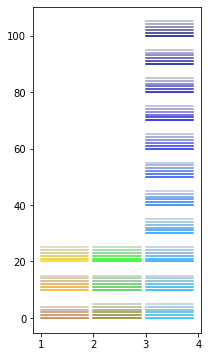

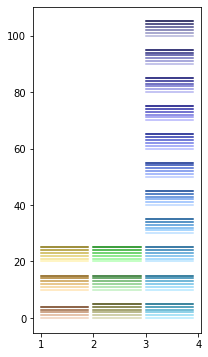

In [2]:
# import own functions
from importnb import Notebook

with Notebook(): 
        import functions as fkts
        import namelist as nml
        from set_up_case_dict import *

In [3]:
nml.dir_sim

'/proj/bolinc/users/x_matsc/my_builds/DYCOMS_limDQC_AO'

In [4]:
nml.bd_time

(17398, 21602)

### some constants

In [5]:
savefigs = False

In [6]:
list(dct_all)

['FDT', 'LRD', 'SMD']

## load parcel model simuation results

In [7]:
dir_pyrcel_out = "/proj/bolinc/users/x_matsc/output/pyrcel/"

In [8]:
pyrcel_act_Num =  pd.read_csv(dir_pyrcel_out + "PYRCEL_act_Num.csv", index_col = 0)

In [9]:
pyrcel_act_fracs = pd.read_csv(dir_pyrcel_out + "PYRCEL_act_fracs.csv", index_col = 0)

# Check out 3d Susceptibility

since this is computationally mode expansice just calcualte one metric!

## All data (up- and downfrafts)

### Calculate mean values (based on 3d output) for all data

In [10]:
def fkt_calc_3d_stats(da, z_wg):
    """
    calculate mean, standard deviation, 25 & 75 percentile
    
    in:
        da ... xarray
    z_wg:
        z_weights
        
    """
    wgAVG = da.weighted(z_wg).mean()
    
    da_wg = da.where(da.Z[z_wg > 0])
       
    std   = da_wg.std()
    qu25  = da_wg.quantile(0.25)
    # use the 50th quantile as proxiy for median 
    ## (median not possible in weighed array)
    qu50  = da_wg.quantile(0.50) 
    qu75  = da_wg.quantile(0.75)
    
    dct_istat = {"means3d": wgAVG,\
                 "std3d": std,\
                 "qu25": qu25,\
                 "qu50": qu50,\
                 "qu75": qu75,\
                }
    
    return dct_istat

In [11]:
def fkt_calc_vertsum(da, z_wg):
    """
    calculate mean, standard deviation, 25 & 75 percentile
    
    in:
        da ... xarray
    z_wg:
        z_weights
        
    """
    
    # domain vertival sum
    dmn_vertsum = da.weighted(z_wg).sum(dim = ["Z"])

    # calculate statistics
    wgAVG = dmn_vertsum.mean()
    std   = dmn_vertsum.std()
    qu25  = dmn_vertsum.quantile(0.25)
    # use the 50th quantile as proxiy for median 
    ## (median not possible in weighed array)
    qu50  = dmn_vertsum.quantile(0.50) 
    qu75  = dmn_vertsum.quantile(0.75)
    
    dct_istat = {"means3d": wgAVG,\
                 "std3d": std,\
                 "qu25": qu25,\
                 "qu50": qu50,\
                 "qu75": qu75,\
                }
    
    return dct_istat

In [12]:
def fkt_calc_3d_means(dir_nc):

    ## select case
    #ids_all = xr.open_dataset(dir_nc)
    with xr.open_dataset(dir_nc) as ids_all:
    
        # subset time and calculate time averave
        time_idx  = (ids_all.time >= nml.bd_time[0]) &\
                    (ids_all.time <= nml.bd_time[1])
        
        if not np.any(time_idx):
            time_idx  = (ids_all.time >=ids_all.time[-1]-3600/2) &\
                        (ids_all.time <=  ids_all.time[-1])
            print("WARNING: chosen time not available! Using last 30min of simulation")
                
                
        ids_sub = ids_all.isel(time = time_idx )
        # calculate the distance between the grid boxes
        z_bd = ids_all["Z_BD"]

        # calculate z weights by calculating the height of the grid boxes
        z_weights = z_bd[:,1] - z_bd[:,0]

        # weights for calulating susceptability
        z_wg4ssptblty = z_weights.copy()
        z_wg4ssptblty[np.where(ids_all["Z"] > nml.z_max)] = 0
        z_wg4ssptblty[np.where(ids_all["Z"] < nml.z_min)] = 0

        #### select only some variables (makes computation quicker)
        ## multiply everything with Rho to 
        # get Number concentrations (and not densities)
        #    kg / kg * kg / m3 --> kg / m3
        #     1 / kg * kg / m3 --> 1 / m3
        ids_sub_vars = ids_sub[["Nc", "Nr","Qc"]]*ids_sub["RHO"]
    
        # add W updraft
        ids_sub_vars = ids_sub_vars.merge(ids_sub["W"])
        
        # add aerosol
        aero_vars = [i for i in list(ids_all) if aero_var in i]
        ids_aero = ids_all[list(ids_all.dims)]
        for iaero_var in aero_vars:
            ids_aero.merge(ids_sub[iaero_var])
        

        # create an empy dict
        aero_vars = [i for i in list(ids_all) if aero_var in i]
        ids_aero = ids_sub[list(ids_sub.dims)]
        
        # create a new variable (initizalized with zeros)
        ids_aero = ids_aero.assign({aero_var: ids_sub["Nc"]*0})

        # sum up all the aerosols variable
        for iaero in aero_vars:
            ids_aero[aero_var] = ids_aero[aero_var]+ids_sub[iaero]
            
        ids_sub_vars = ids_sub_vars.merge(ids_aero)

        # in cloud calues only
        ids_sub_vars_cl = ids_sub_vars.where(ids_sub["Qc"] >= 1e-7)
        
        # initalize return dict
        icase_stats = {}
        # all hights
        icase_stats.update({"all":fkt_calc_3d_stats(da = ids_sub_vars, z_wg = z_weights)})
        icase_stats.update({"all_vertsum":fkt_calc_vertsum(da = ids_sub_vars, z_wg = z_weights)})
        
        # in cloud values
        icase_stats.update({"in_cloud":fkt_calc_3d_stats(da = ids_sub_vars_cl, z_wg = z_weights)})   
        icase_stats.update({"in_cloud_vertsum":fkt_calc_vertsum(da = ids_sub_vars_cl, z_wg = z_weights)})

        # below cloud values
        icase_stats.update({"below_cloud":fkt_calc_3d_stats(da = ids_sub_vars, z_wg = z_wg4ssptblty)})


    return icase_stats

In [13]:
## set up a dict to store the data

dct_stats = {}

for sgrp in dct_all:
    dct_igrp = {}
    for stype in dct_all[sgrp]:
        dct_itype = {}
        for scase in dct_all[sgrp][stype]:
            dct_itype.update({scase:{
                                    "aero_all":{"means3d": np.nan,"std3d":  np.nan,"qu25":  np.nan,"qu50":  np.nan,"qu75":  np.nan},\
                                    "aero_below_cl":{"means3d": np.nan,"std3d":  np.nan,"qu25":  np.nan,"qu50":  np.nan,"qu75":  np.nan},\
                                    "Nc":{"means3d": np.nan,"std3d":  np.nan,"qu25":  np.nan,"qu50":  np.nan,"qu75":  np.nan},\
                                    "Nr":{"means3d": np.nan,"std3d":  np.nan,"qu25":  np.nan,"qu50":  np.nan,"qu75":  np.nan},\
                                    "Nc_vertsum":{"means3d": np.nan,"std3d":  np.nan,"qu25":  np.nan,"qu50":  np.nan,"qu75":  np.nan},\
                                    "Nr_vertsum":{"means3d": np.nan,"std3d":  np.nan,"qu25":  np.nan,"qu50":  np.nan,"qu75":  np.nan},\
                                    "Nc@inCloud_avg":{"means3d": np.nan,"std3d":  np.nan,"qu25":  np.nan,"qu50":  np.nan,"qu75":  np.nan},\
                                    "Nr@inCloud_avg":{"means3d": np.nan,"std3d":  np.nan,"qu25":  np.nan,"qu50":  np.nan,"qu75":  np.nan},\
                                    "Nc@inCloud_vertsum":{"means3d": np.nan,"std3d":  np.nan,"qu25":  np.nan,"qu50":  np.nan,"qu75":  np.nan},\
                                    "Nr@inCloud_vertsum":{"means3d": np.nan,"std3d":  np.nan,"qu25":  np.nan,"qu50":  np.nan,"qu75":  np.nan}}
                             })
        dct_igrp.update({stype:dct_itype})
    dct_stats.update({sgrp:dct_igrp})



### Calculate statistics 

In [14]:
# specify the aerosol variable
aero_var = "N_AERO"

for sgrp in dct_all:
    dct_igrp = {}
    for stype in dct_all[sgrp]:
        dct_itype = {}
        for scase in dct_all[sgrp][stype]:
            print("Start {}/{}/{}".format(sgrp, stype, scase))



            ## calculate the statistics
            icase_stats = fkt_calc_3d_means(dir_nc = dct_all[sgrp][stype][scase]["dir_3d"])



            ## write the values to a df    
            for istat in dct_stats[sgrp][stype][scase]["aero_all"]:
                ##### aerosols
                dct_stats[sgrp][stype][scase]["aero_all"][istat] = icase_stats["all"][istat][aero_var]
                dct_stats[sgrp][stype][scase]["aero_below_cl"][istat] = icase_stats["below_cloud"][istat][aero_var]

                ####### CDNC
                ### all heights
                dct_stats[sgrp][stype][scase]["Nc"][istat] = icase_stats["all"][istat]["Nc"]
                dct_stats[sgrp][stype][scase]["Nr"][istat] = icase_stats["all"][istat]["Nr"]

                dct_stats[sgrp][stype][scase]["Nc_vertsum"][istat] = icase_stats["all_vertsum"][istat]["Nc"]
                dct_stats[sgrp][stype][scase]["Nr_vertsum"][istat] = icase_stats["all_vertsum"][istat]["Nr"]

                # get Nr+Nc in cloud averages
                dct_stats[sgrp][stype][scase]["Nc@inCloud_avg"][istat] = icase_stats["in_cloud"][istat]["Nc"]
                dct_stats[sgrp][stype][scase]["Nr@inCloud_avg"][istat] = icase_stats["in_cloud"][istat]["Nr"]

                # get Nc + Nr vertsum
                dct_stats[sgrp][stype][scase]["Nc@inCloud_vertsum"][istat] = icase_stats["in_cloud_vertsum"][istat]["Nc"]
                dct_stats[sgrp][stype][scase]["Nr@inCloud_vertsum"][istat] = icase_stats["in_cloud_vertsum"][istat]["Nr"]


print("--> All done <--")

Start FDT/dt_1e-1_r0_1e-6/10e07
Start FDT/dt_1e-1_r0_1e-6/10e08
Start FDT/dt_1e-1_r0_1e-6/10e09
Start FDT/dt_1e-1_r0_1e-6/10e10
Start FDT/dt_1e-1_r0_1e-6/65e06
Start FDT/dt_1e-1_r0_rwet/10e07
Start FDT/dt_1e-1_r0_rwet/10e08
Start FDT/dt_1e-1_r0_rwet/10e09
Start FDT/dt_1e-1_r0_rwet/10e10
Start FDT/dt_1e-1_r0_rwet/50e07
Start FDT/dt_1e-1_r0_rwet/65e06
Start FDT/dt_1e-1_r0_rwet_noREN/10e07
Start FDT/dt_1e-1_r0_rwet_noREN/10e08
Start FDT/dt_1e-1_r0_rwet_noREN/10e09
Start FDT/dt_1e-1_r0_rwet_noREN/10e10
Start FDT/dt_1e-1_r0_rwet_noREN/50e07
Start FDT/dt_1e-1_r0_rwet_noREN/65e06
Start LRD/r0_01e-06/10e07
Start LRD/r0_01e-06/10e08
Start LRD/r0_01e-06/10e09
Start LRD/r0_01e-06/10e10
Start LRD/r0_01e-06/50e07
Start LRD/r0_01e-06/65e06
Start LRD/r0_05e-06/10e07
Start LRD/r0_05e-06/10e08
Start LRD/r0_05e-06/10e09
Start LRD/r0_05e-06/10e10
Start LRD/r0_05e-06/50e07
Start LRD/r0_05e-06/65e06
Start LRD/r0_10e-06/10e07
Start LRD/r0_10e-06/10e08
Start LRD/r0_10e-06/10e09
Start LRD/r0_10e-06/10e10
Star

In [15]:
dct_stats["LRD"]["r0_01e-06"]["65e06"]["Nr@inCloud_avg"]

{'means3d': <xarray.DataArray 'Nr' ()>
 array(34138.13856557),
 'std3d': <xarray.DataArray 'Nr' ()>
 array(31560.96875),
 'qu25': <xarray.DataArray 'Nr' ()>
 array(15698.71484375)
 Coordinates:
     quantile  float64 0.25,
 'qu50': <xarray.DataArray 'Nr' ()>
 array(35077.76953125)
 Coordinates:
     quantile  float64 0.5,
 'qu75': <xarray.DataArray 'Nr' ()>
 array(57479.3515625)
 Coordinates:
     quantile  float64 0.75}

### plot 3d susceptiblity

#### plot based on 3d data

In [16]:
def fkt_plot_LNreg_3d(ax, x_in, y_in,
                      yqu25, yqu75,
                      label_in, color, marker=".",\
                      lwd = 1,\
                      zord = 1,\
                      anot_casename=False,\
                      draw_RegLine = False):
    
    # for the linear regression
    # mask out extrem low values
    mk = np.where((y_in > 1) & (x_in > 10))[0]
    try:
        reg_LN = scipy.stats.linregress(x=np.log(x_in[mk]), y=np.log(y_in[mk]))
    except:
        print("Regression not possible for ", label_in)

    if False:
        label_print = label_in + "\n" +\
            "$y = " + "{0:3.2f}".format(reg_LN.intercept) +\
            "* x^" + "{" + "{0:3.2f}".format(reg_LN.slope) + "}$"
    else:
        label_print = label_in
    
    
    if False:
        # plot only means
        ax.scatter(x=x_in, y=y_in,
                   label=label_print,\
                   color = color,\
                   alpha = 1,\
                   marker=marker,\
                   zorder = zord)
        
    else:
        # plot with errorbars
        err1 = ax.errorbar(x=x_in, y=y_in,
                            #xerr=np.array([x_in - xqu25, xqu75 - x_in]),
                            yerr=np.array([y_in - yqu25, yqu75- y_in]),
                            label=label_print,\
                            color = color,\
                            markersize = 5,\
                            markerfacecolor=color,\
                            alpha = 1,\
                            marker=marker,\
                            linestyle = (0,(3,1)),\
                            linewidth = lwd/2,\
                            elinewidth = lwd,\
                            capsize = lwd,\
                            zorder = zord)
        # change alpha of the line only
        ch1 = err1.get_children()
        ch1[0].set_alpha(0.5)
        # make sure lines are always behind the errorbars (for all lines)
        ch1[0].set_zorder(zord/50)

    if anot_casename:
        for ilbl in x_in.index:
            ax.annotate(ilbl, xy=(x_in.loc[ilbl], y_in.loc[ilbl]),
                        fontsize=8, label=None)
    try:
        if draw_RegLine:
            ax.plot(sorted(x_in), np.exp(reg_LN.intercept) * sorted(x_in) ** reg_LN.slope,
                    color=color, linestyle="-", label='_nolegend_',\
                    linewidth = 7, alpha = 0.25, zorder = 2)
        return reg_LN
    except:
        print("No regression line")
        return np.nan
   

In [17]:
beta_dct = {}
for sgrp in dct_all:
    dct_sgrp = {}
    for stype in dct_all[sgrp]:
        dct_sgrp.update({stype:np.nan})
    beta_dct.update({sgrp:dct_sgrp})
    

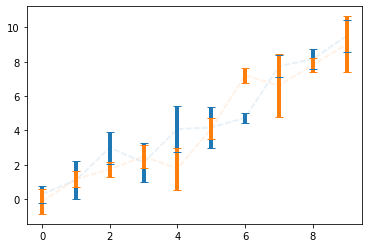

In [18]:
# errobar plot testing
if True:
    err1 = plt.errorbar(x = np.arange(10),\
                 y = np.arange(10)+np.random.randn(10), 
                 yerr = np.random.randn(10),\
                markersize = 2,\
                alpha = 1,\
                marker=None,\
                linestyle = (0,(3,1)),\
                linewidth = 2,\
                elinewidth = 4,\
                capsize = 4)

    ch1 = err1.get_children()

    ch1[0].set_alpha(0.1)
    ch1[0].set_zorder(0.1)
    
    err2 = plt.errorbar(x = np.arange(10),\
                 y = np.arange(10)+np.random.randn(10), 
                 yerr = np.random.randn(10),\
                markersize = 2,\
                alpha = 1,\
                marker=None,\
                linestyle = (0,(3,1)),\
                linewidth = 2,\
                elinewidth = 4,\
                capsize = 4)

    ch1 = err2.get_children()

    ch1[0].set_alpha(0.1)
    ch1[0].set_zorder(0.1)

### Make to plot

In [19]:
pyrcel_act_Num.columns[iV]

NameError: name 'iV' is not defined

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = [8,6])
#ig = plt.figure(figsize = [8,8])
#x = fig.add_axes([0.1,0.1,.8,0.8])

ax.set_xscale("log")
ax.set_yscale("log")
#ax.loglog()

Aero_var = "aero_below_cl"

nc_var = "Nc@inCloud_avg"
nr_var = "Nr@inCloud_avg"# "Nr@inCloud_avg"

Aero_scale = 10**6
Nc_scale = 10**6

        
for sgrp in dct_all:
    for stype in dct_all[sgrp]:

        aero_q50 = pd.DataFrame(index = list(dct_all[sgrp][stype]))
        aero_q75 = pd.DataFrame(index = list(dct_all[sgrp][stype]))
        aero_q25 = pd.DataFrame(index = list(dct_all[sgrp][stype]))

        cdnc_q50 = pd.DataFrame(index = list(dct_all[sgrp][stype]))
        cdnc_q75 = pd.DataFrame(index = list(dct_all[sgrp][stype]))
        cdnc_q25 = pd.DataFrame(index = list(dct_all[sgrp][stype]))                     

        for scase in dct_all[sgrp][stype]:
            aero_q50.loc[scase, Aero_var] = (dct_stats[sgrp][stype][scase][Aero_var]["qu50"].values)/Aero_scale
            aero_q75.loc[scase, Aero_var] = (dct_stats[sgrp][stype][scase][Aero_var]["qu75"].values)/Aero_scale
            aero_q25.loc[scase, Aero_var] = (dct_stats[sgrp][stype][scase][Aero_var]["qu25"].values)/Aero_scale

            cdnc_q50.loc[scase, "CDNC"] = (dct_stats[sgrp][stype][scase][nc_var]["qu50"].values +  dct_stats[sgrp][stype][scase][nr_var]["qu50"].values )/Nc_scale
            cdnc_q75.loc[scase, "CDNC"] = (dct_stats[sgrp][stype][scase][nc_var]["qu75"].values +  dct_stats[sgrp][stype][scase][nr_var]["qu75"].values )/Nc_scale
            cdnc_q25.loc[scase, "CDNC"] = (dct_stats[sgrp][stype][scase][nc_var]["qu25"].values +  dct_stats[sgrp][stype][scase][nr_var]["qu25"].values )/Nc_scale

        #for itype in ["Dc010e-5m"]:
        all_cases = list(dct_all[sgrp][stype])
        agsort_cases = fkts.listargsort(all_cases)
        col_case = all_cases[agsort_cases[-1]]

        cdnc_idx = np.argsort(cdnc_q50)

        reg_LN = fkt_plot_LNreg_3d(\
                       ax=ax,\
                       x_in=aero_q50.sort_values(by=Aero_var).values.flatten(),\
                       y_in=cdnc_q50.sort_values(by="CDNC").values.flatten(),\
                       yqu25=cdnc_q25.sort_values(by="CDNC").values.flatten(),\
                       yqu75=cdnc_q75.sort_values(by="CDNC").values.flatten(),\
                       label_in=dct_all[sgrp][stype][scase]["label"],
                       color=dct_all[sgrp][stype][col_case]["color"],
                       marker="",\
                       lwd=dct_all[sgrp][stype][col_case]["lw"],\
                       zord= dct_all[sgrp][stype][col_case]["zord"],\
                       anot_casename=False,\
                       draw_RegLine=False)

        beta_dct[sgrp][stype] =  reg_LN.slope

if False:
    ## add results from parcel model simulations
    for iV in range(len(pyrcel_act_Num.columns))[::-1]:

        ax.plot(pyrcel_act_Num.index[:-1], pyrcel_act_Num.iloc[:-1,iV],"-",
                linewidth = 0.75,\
                label = "w = {0:3.1f} m/s".format(float(pyrcel_act_Num.columns[iV])),\
                color = mpl.cm.binary(np.linspace(100,200, len(pyrcel_act_Num.columns),dtype=int)[iV]),\
                alpha = 0.6, \
                zorder = -99)        
        
# add some labels and a grid
ax.set_xlabel("$\mathbf{N_a}$  $\mathbf{[cm^{-3}]}$", fontweight = "bold")
ax.set_ylabel("$\mathbf{N_d}$  $\mathbf{[cm^{-3}]}$", fontweight = "bold")
#ax.tick_params(axis='both', which='major', labelsize=12, width=2.5, length=10)
#ax.tick_params(axis='both', which='minor', labelsize=4, width=1.5, length=6)

for iax in [ax.xaxis, ax.yaxis]:
    iax.set_major_formatter(FormatStrFormatter('%g'))

if True:
    ax.grid(which='major', axis='both', alpha=0.1, color = "black")
    ax.grid(which='minor', axis='both', alpha=0.05, color = "grey")

# add legend outside of plot
lgd = plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5),\
                  fontsize = 8, ncol = 1, handlelength=4, frameon =False).set_zorder(0)

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:E}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:G}'))

xtick_lbs = ["$\mathbf{"+"10^{0}".format(int(i))+"}$" for i in np.log10(ax.get_xticks())]
ytick_lbs = ["$\mathbf{"+"10^{0}".format(int(i))+"}$" for i in np.log10(ax.get_yticks())]
ax.set_xticklabels(xtick_lbs)
ax.set_yticklabels(ytick_lbs)




# make the background transparent
ax.set_facecolor("white")
fig.set_facecolor((0,0,0,0))
fig.set_edgecolor((0,0,0,0))


# equal axis in both directions
ax.set_aspect('equal', adjustable='box')

ax.set_xlim([4e1,1e5])
ax.set_ylim([4e1,3e4])
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()

### Remove spines and draw arrows instead
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# make arrows
ax.plot((xmin, xmax*1.2), (ymin, ymin), color = "k",clip_on=False )
ax.plot((xmax*1.2), (ymin), ls="", marker=">", ms=8, color="k",clip_on=False)

ax.plot((xmin, xmin), (ymin, ymax*1.2), color = "k",clip_on=False )
ax.plot((xmin), (ymax*1.2), ls="", marker="^", ms=8, color="k",clip_on=False)

if True:
    # 1:1 line grid
    for igrid in np.arange(-5,6,1, dtype = float):
        ax.plot([10**(igrid+1), 10**(igrid+6)], [10**1, 10**6], color = "grey", alpha = 0.05,\
               linestyle = "-")


if savefigs:
    plt.savefig(os.path.join(nml.dir_output, "Na_belowCloud_vs_CDNCinCloudAVG_3d.png"),
            bbox_inches="tight",dpi = 500)

In [60]:
savefigs = False

In [29]:
savefigs = True

In [22]:
os.path.join(nml.dir_output, "Na_belowCloud_vs_CDNCinCloudAVG_3d.png")

'/proj/bolinc/users/x_matsc/output/DYCOMS_limDQC_AO/Na_belowCloud_vs_CDNCinCloudAVG_3d.png'

In [23]:
pd.options.display.float_format = '{:,.2f}'.format
beta.T

NameError: name 'beta' is not defined

In [ ]:
beta1 = beta[1:].copy()

In [ ]:
beta1

In [ ]:
fix, ax = plt.subplots()

x = []
lbs =  []
for itype in range(len(beta1.index)):
    typ = beta1.index[itype]
    
    col_case = list(dct_all[typ])[0]
    
    x.append(itype)
    lbs.append(typ)
    bar1 = ax.barh(y = itype, width = beta1.loc[typ],  label = typ,\
           color = dct_all[typ][col_case]["color"] )
    ax.text(y = itype, x = beta1.loc[typ],\
            s = "{0:3.2f}".format(float(beta1.loc[typ])),\
           fontsize = 8, ha = "left", va ="center")

ax.set_yticks(x)
ax.set_yticklabels(lbs,ha = "right", fontsize = 8)

ax.set_title("Susceptibility\n d ln(CDCN)/ d ln (Na)")

if savefigs:
    plt.savefig(os.path.join(nml.dir_output, "Na_belowCloud_vs_CDNCinCloudAVG_3d_bar.pdf"),
                bbox_inches="tight", dpi=300)

In [ ]:
ax.get_xticks()

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
beta.iloc[1:,-1]

In [ ]:
"Mean = {0:3.2f} Spreas = [{1:3.2f},{2:3.2f}]".format(beta.iloc[1:,-1].mean(),\
                                       beta.iloc[1:,-1].min(),\
                                       beta.iloc[1:,-1].max())